<a href="https://colab.research.google.com/github/ejrtks1020/Pytorch-basic/blob/main/Pytorch_%EC%86%8C%ED%94%84%ED%8A%B8%EB%A7%A5%EC%8A%A4_%ED%9A%8C%EA%B7%80_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 파이토치로 소프트맥스의 비용함수 구현하기(로우-레벨)

In [ ]:
import torch
import torch.nn.functional as F

In [ ]:
# 소프트맥스 함수의 입력
z = torch.FloatTensor([1,2,3])

hypothesis = F.softmax(z, dim = 0)
print(hypothesis)

tensor([0.0900, 0.2447, 0.6652])


In [ ]:
print(hypothesis.sum()) # 총 원소의 값이 1임을 확인

tensor(1.)


In [ ]:
# 비용함수 직접구현

# 3 x 5 크기의 텐서 (5개의 클래스를 가지는 샘플 3개)
z = torch.rand(3, 5, requires_grad=True)
print(z)

# 각 샘플에 대해서 소프트맥스 함수를 적용해야 하므로 두번째 차원에 대해 소프트함수를 적용한다는 의미에서 dim = 1
hypothesis = F.softmax(z, dim = 1)
print(hypothesis)


tensor([[0.8962, 0.9662, 0.7883, 0.1128, 0.2904],
        [0.8924, 0.1649, 0.6870, 0.9071, 0.1010],
        [0.1788, 0.7416, 0.0960, 0.8258, 0.5820]], requires_grad=True)
tensor([[0.2517, 0.2700, 0.2260, 0.1150, 0.1373],
        [0.2656, 0.1283, 0.2163, 0.2695, 0.1204],
        [0.1412, 0.2479, 0.1300, 0.2696, 0.2113]], grad_fn=<SoftmaxBackward0>)


각 행의 원소들의 합은 1이 되는 텐서로 변환

위 텐서는 3개의 샘플에 대해서 5개의 클래스중 어떤 클래스가 정답인지를 예측한 결과

In [ ]:
#각 샘플에 대해 임의의 레이블 생성
y = torch.randint(5, (3,)).long()
print(y)

tensor([0, 4, 2])


In [ ]:
y.unsqueeze(1)

tensor([[0],
        [4],
        [2]])

In [ ]:
# 원-핫 인코딩 수행
# 모든 원소가 0의 값을 가진 3 x 5 텐서 생성
y_one_hot = torch.zeros_like(hypothesis)
y_one_hot.scatter_(1, y.unsqueeze(1), 1) # dimension , index, value
# 연산뒤에 '_'를 붙이면 Inplace 연산(덮어쓰기)

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.]])

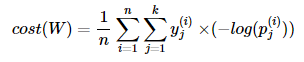

* 소프트 맥스 회귀의 비용함수

In [ ]:
cost = (y_one_hot * torch.log(hypothesis)).sum(dim = 1).mean()
print(cost)

tensor(-1.8457, grad_fn=<MeanBackward0>)


#2. 파이토치로 소프트맥스의 비용함수 구현하기(하이-레벨)

## 1. F.softmax() + torch.log() = F.log_softmax()

In [ ]:
# Low level
torch.log(F.softmax(z, dim = 1))

tensor([[-1.3795, -1.3095, -1.4873, -2.1628, -1.9853],
        [-1.3259, -2.0533, -1.5313, -1.3112, -2.1173],
        [-1.9576, -1.3948, -2.0404, -1.3106, -1.5544]], grad_fn=<LogBackward0>)

In [ ]:
# high level
F.log_softmax(z, dim = 1)

tensor([[-1.3795, -1.3095, -1.4873, -2.1628, -1.9853],
        [-1.3259, -2.0533, -1.5313, -1.3112, -2.1173],
        [-1.9576, -1.3948, -2.0404, -1.3106, -1.5544]],
       grad_fn=<LogSoftmaxBackward0>)

## 2. F.log_softmax() + F.nll_loss() = F.cross_entropy()

In [ ]:
# Low level 비용함수
# 첫 번째 수식
(y_one_hot * -torch.log(F.softmax(z, dim = 1))).sum(dim = 1).mean()

tensor(1.8457, grad_fn=<MeanBackward0>)

In [ ]:
# 두번째 수식
(y_one_hot * - F.log_softmax(z,dim = 1)).sum(dim = 1).mean()

tensor(1.8457, grad_fn=<MeanBackward0>)

In [ ]:
# High level
# 세번째 수식
F.nll_loss(F.log_softmax(z, dim = 1), y) #nll : Negative Log Likelihood

tensor(1.8457, grad_fn=<NllLossBackward0>)

In [ ]:
# 네번째 수식
F.cross_entropy(z, y) # F.cross_entropy()는 F.log_softmax()와 F.nll_loss()를 포함하고 있음

tensor(1.8457, grad_fn=<NllLossBackward0>)

#3. 소프트맥스 회귀 구현하기

* 소프트맥스 회귀를 로우-레벨과 F.cross_entropy를 사용해서 구현

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1)

In [ ]:
X_train = [[1, 2, 1, 1],
           [2, 1, 3, 2],
           [3, 1, 3, 4],
           [4, 1, 5, 5],
           [1, 7, 5, 5],
           [1, 2, 5, 6],
           [1, 6, 6, 6],
           [1, 7, 7, 7]]
y_train = [2, 2, 2, 1, 1, 1, 0, 0]
X_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

학습데이터는 4개의 특성을 가지고 총 8개의 샘플이 존재한다.
y_train은 0,1,2 총 3개의 클래스가 존재한다

##3-1. 소프트맥스 회구 구현(로우 레벨)

In [ ]:
print(X_train.shape)
print(y_train.shape)

torch.Size([8, 4])
torch.Size([8])


최동 사용할 레이블은 y_train에서 원-핫 인코딩을 한 결과이어야 한다.

클래스 개수는 3개이므로 y_train에 원-핫 인코딩한 결과는 8 x 3의 개수를 가져야 한다

In [ ]:
y_one_hot = torch.zeros(8, 3)
y_one_hot.scatter_(1, y_train.unsqueeze(1), 1)
print(y_one_hot)

tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]])


y_one_hot의 크기는 8 x 3이므로 W행렬의 크기는 4 x 3이어야 함

-> 8 x 4  *  4 x 3 = 8 x 3

W와 b를 선언하고 , 옵티마이저로는 경사 하강법을 사용하고 학습률은 0.1로 설정

In [ ]:
#모델 초기화
W = torch.zeros((4,3), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# optimizer 설정
optimizer = optim.SGD([W,b], lr = 0.1)

In [ ]:
epochs = 1000
for epoch in range(epochs + 1):

  # 가설
  hypothesis = F.softmax(X_train.matmul(W) + b, dim = 1)

  # 비용 함수
  cost = (y_one_hot * -torch.log(hypothesis)).sum(dim = 1).mean()

  # cost로 H(x) 개선
  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  # 100번마다 로그 출력
  if epoch % 100 == 0:
    print("Epoch {:4d}/{} Cost{:.6f}".format(
        epoch, epochs, cost.item()
    ))



Epoch    0/1000 Cost1.098612
Epoch  100/1000 Cost0.761050
Epoch  200/1000 Cost0.689991
Epoch  300/1000 Cost0.643229
Epoch  400/1000 Cost0.604117
Epoch  500/1000 Cost0.568255
Epoch  600/1000 Cost0.533922
Epoch  700/1000 Cost0.500291
Epoch  800/1000 Cost0.466908
Epoch  900/1000 Cost0.433507
Epoch 1000/1000 Cost0.399962


#3-2 소프트맥스 회귀 구현하기(하이- 레벨)

F.cross_entropy 사용 (주의 : 가설에서 소프트맥스 함수 사용할 필요없음)

In [ ]:
# 모델 초기화
W = torch.zeros((4,3), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# optimizer 설정
optimizer = optim.SGD([W, b], lr = 0.1)
epochs = 1000
for epoch in range(epochs + 1):
  
  # Cost 계산
  z = X_train.matmul(W) + b
  cost = F.cross_entropy(z, y_train)

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  if epoch % 100 == 0:
    print('Epoch {:4d}/{} Cost: {:.6f}'.format(
        epoch, epochs, cost.item()
    ))


Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.761050
Epoch  200/1000 Cost: 0.689991
Epoch  300/1000 Cost: 0.643229
Epoch  400/1000 Cost: 0.604117
Epoch  500/1000 Cost: 0.568256
Epoch  600/1000 Cost: 0.533922
Epoch  700/1000 Cost: 0.500291
Epoch  800/1000 Cost: 0.466908
Epoch  900/1000 Cost: 0.433507
Epoch 1000/1000 Cost: 0.399962


#3-3. 소프트맥스 회귀 nn.Module로 구현하기

선형회귀 구현에 사용했던 nn.Linear()사용, output_dim = 1 이었던 선형회귀때와는 달리 output_dim은 이제 클래스의 개수여야한다.

In [ ]:
# 모델을 선언 및 초기화. 4개의 특성을 가지고 3개의 클래스로 분류. input_dim =4, output_dim = 3
model = nn.Linear(4,3)

optimizer = optim.SGD(model.parameters(), lr = 0.1)
epochs = 1000
for epoch in range(epochs + 1):

  # H(x) 계산
  pred = model(X_train)

  #cost 계산
  cost = F.cross_entropy(pred, y_train)

  #H(x) 개선
  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  if epoch % 100 == 0:
    print('Epoch {:4d}/{} Cost {}'.format(
        epoch, epochs, cost.item()
    ))

Epoch    0/1000 Cost 1.6167852878570557
Epoch  100/1000 Cost 0.6588907837867737
Epoch  200/1000 Cost 0.5734434723854065
Epoch  300/1000 Cost 0.5181514024734497
Epoch  400/1000 Cost 0.47326546907424927
Epoch  500/1000 Cost 0.4335159659385681
Epoch  600/1000 Cost 0.3965628743171692
Epoch  700/1000 Cost 0.36091411113739014
Epoch  800/1000 Cost 0.3253922164440155
Epoch  900/1000 Cost 0.28917840123176575
Epoch 1000/1000 Cost 0.25414788722991943


#3-4. 소프트 맥스 회귀 클래스로 구현하기

소프트맥스 회귀를 nn.Module을 상속받은 클래스로 구현

In [ ]:
class SoftmaxClassifierModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Linear(4, 3)

  def forward(self, x):
    return self.model(x)

In [ ]:
model = SoftmaxClassifierModel()

optimizer = optim.SGD(model.parameters(), lr = 0.1)

epochs = 1000
for epoch in range(epochs + 1):

  pred = model(X_train)

  cost = F.cross_entropy(pred, y_train)

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  if epoch % 100 == 0:
    print('Epoch {:4d}/{}\tCost {:.6f}'.format(
        epoch, epochs, cost.item()
    ))

Epoch    0/1000	Cost 2.894385
Epoch  100/1000	Cost 0.713320
Epoch  200/1000	Cost 0.631103
Epoch  300/1000	Cost 0.573847
Epoch  400/1000	Cost 0.523610
Epoch  500/1000	Cost 0.476214
Epoch  600/1000	Cost 0.430079
Epoch  700/1000	Cost 0.384448
Epoch  800/1000	Cost 0.338987
Epoch  900/1000	Cost 0.294060
Epoch 1000/1000	Cost 0.253870


In [ ]:
torch.zeros((4,3)) + torch.Tensor([1])

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])